In [ ]:
!pip install -q wikipedia
!pip install -q sentence-transformers umap-learn keybert


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00


In [ ]:
import wikipedia
import random

# Choose categories to pull summaries from
topics = ["Artificial intelligence", "Philosophy", "Genetics", "Climate change", "World War II", "Blockchain", "Economics", "Quantum mechanics", "Indian History", "Linguistics"]

summaries = []
labels = []

for topic in topics:
    try:
        related_pages = wikipedia.search(topic, results=100)
        for title in related_pages:
            try:
                summary = wikipedia.summary(title)
                summaries.append(summary)
                labels.append(topic)
            except Exception:
                continue
    except Exception:
        continue

print(f"Total articles collected: {len(summaries)}")


/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Total articles collected: 885


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(summaries, show_progress_bar=True)


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=3)
cluster_labels = dbscan.fit_predict(embedding_2d)

print(f"Clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")


Clusters found: 10


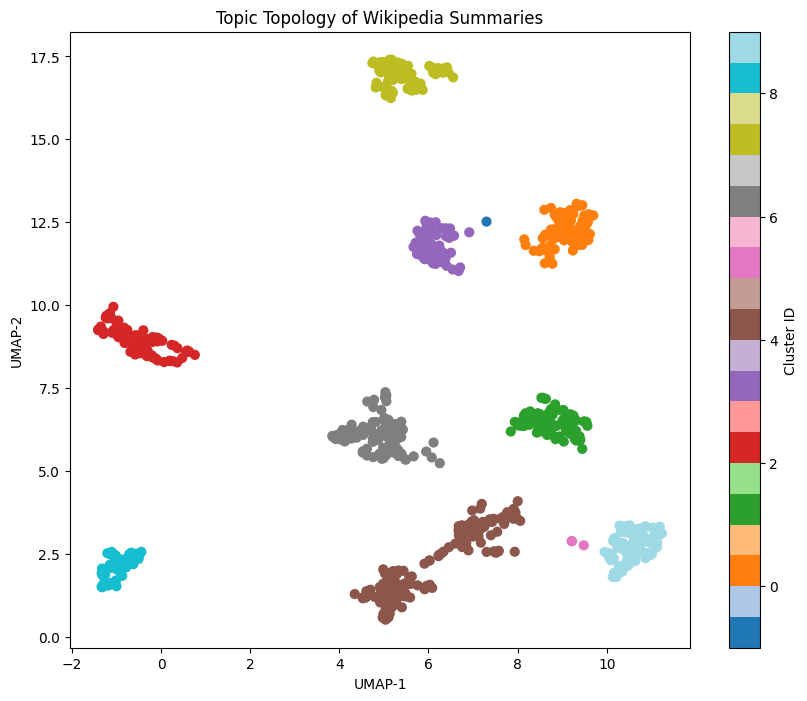

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='tab20', s=40)
plt.title("Topic Topology of Wikipedia Summaries")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.show()


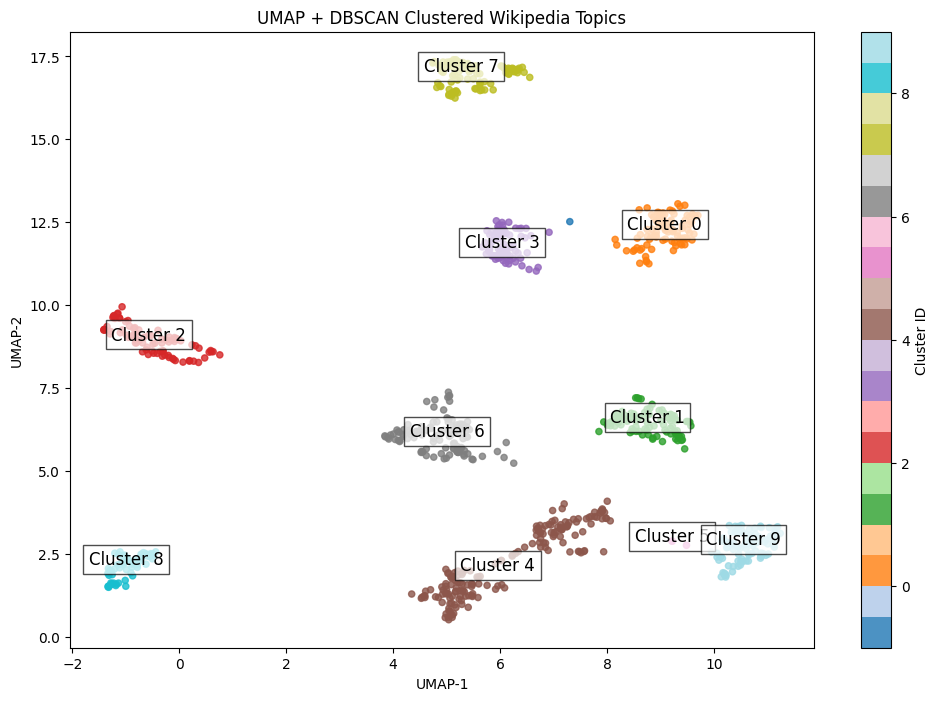

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume:
# - embedding_2d is your UMAP result (shape: [N, 2])
# - cluster_labels is your DBSCAN result (shape: [N])

plt.figure(figsize=(12, 8))

# Scatter plot
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=cluster_labels,
    cmap='tab20',
    s=20,
    alpha=0.8
)

# Plot title and labels
plt.title("UMAP + DBSCAN Clustered Wikipedia Topics")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Label each cluster with its number at the median location
unique_clusters = np.unique(cluster_labels)
for cluster_id in unique_clusters:
    if cluster_id == -1:
        continue  # skip noise

    # Find the points in this cluster
    cluster_points = embedding_2d[cluster_labels == cluster_id]

    # Compute median position
    median_x, median_y = np.median(cluster_points, axis=0)

    # Plot cluster label at median
    plt.text(median_x, median_y, f"Cluster {cluster_id}", fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7), ha='center')

plt.colorbar(scatter, label="Cluster ID")
plt.show()


In [ ]:
from keybert import KeyBERT
from collections import defaultdict

kw_model = KeyBERT(model)

cluster_to_summaries = defaultdict(list)
for i, label in enumerate(cluster_labels):
    if label == -1:
        continue  # skip noise
    cluster_to_summaries[label].append(summaries[i])

# Print top keywords for each cluster
for cluster_id, cluster_texts in cluster_to_summaries.items():
    joined = " ".join(cluster_texts[:10])
    keywords = kw_model.extract_keywords(joined, top_n=5)
    print(f"\n🔹 Cluster {cluster_id}:")
    for kw in keywords:
        print(f" - {kw[0]} ({kw[1]:.2f})")



🔹 Cluster 0:
 - ai (0.63)
 - intelligence (0.46)
 - chatbots (0.40)
 - google (0.36)
 - autonomous (0.36)

🔹 Cluster 1:
 - reflection (0.49)
 - linguistics (0.44)
 - linguistic (0.43)
 - language (0.42)
 - vernacular (0.42)

🔹 Cluster 2:
 - warming (0.49)
 - climate (0.44)
 - co2 (0.41)
 - emissions (0.39)
 - carbon (0.35)

🔹 Cluster 3:
 - unix (0.57)
 - informatics (0.54)
 - programming (0.41)
 - philosophy (0.33)
 - platform (0.33)

🔹 Cluster 4:
 - philosophy (0.62)
 - philosophical (0.52)
 - philosophers (0.49)
 - philosophia (0.43)
 - philosophía (0.43)

🔹 Cluster 5:
 - mathematics (0.55)
 - mathematical (0.48)
 - philosophy (0.38)
 - physical (0.28)
 - abstract (0.28)

🔹 Cluster 6:
 - philosophers (0.41)
 - philosophy (0.39)
 - degree (0.36)
 - anthologies (0.36)
 - literary (0.36)

🔹 Cluster 7:
 - biology (0.58)
 - biological (0.50)
 - biochemistry (0.46)
 - genomics (0.44)
 - biotechnology (0.44)

🔹 Cluster 8:
 - 1914 (0.47)
 - 1918 (0.47)
 - war (0.47)
 - wars (0.44)
 - 1917 (